In [1]:
import os
from dotenv import load_dotenv
import nibabel as nib
from nibabel.orientations import aff2axcodes
import h5py
import pandas as pd
import numpy as np
from tqdm import tqdm

from utils.registration import nifit_info, correct4registration, slice2chunk_align
from utils.preproc import FUSCleaner

from utils.glm import run_glm_analysis
from nilearn.glm.contrasts import compute_contrast
from scipy.ndimage import affine_transform
import SimpleITK as sitk

import matplotlib.pyplot as plt
import seaborn as sns

from joblib import Parallel, delayed

In [2]:
load_dotenv()
base_dir = os.getenv('BASE_DIR')
task_dir = os.path.join(base_dir, 'task_data')
register_dir = os.path.join(base_dir, 'slice2chunk_grouper', '061824_1-5')

# Registration

In [ ]:
def transform_affine(affine_matrix):
    # Make a copy to avoid modifying the original matrix
    transformed_matrix = affine_matrix.copy()
    
    # Flip the signs of the first and third diagonal elements
    transformed_matrix[0, 0] = -affine_matrix[0, 0]
    transformed_matrix[2, 2] = -affine_matrix[2, 2]
    
    # Set the translation components (last column) to 0
    transformed_matrix[0, 3] = 0
    transformed_matrix[2, 3] = 0
    
    return transformed_matrix

In [5]:
raw_file = os.path.join(task_dir, '0618_livemarmoset_plane1.5.nii')
raw_file2 = os.path.join(register_dir, '0618_livemarmoset_plane1.5.nii.gz')

raw_image = nib.load(raw_file)
raw_image2 = nib.load(raw_file2)

aff2axcodes(raw_image.affine), aff2axcodes(raw_image2.affine)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


(('L', 'A', 'S'), ('R', 'A', 'I'))

In [6]:
raw_image.affine, raw_image2.affine

(array([[-0.11      ,  0.        ,  0.        ,  6.98499996],
        [ 0.        ,  0.40000001,  0.        , -0.        ],
        [ 0.        ,  0.        ,  0.09856   , -6.99775986],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]),
 array([[ 0.11      ,  0.        ,  0.        , -0.        ],
        [ 0.        ,  0.40000001,  0.        , -0.        ],
        [ 0.        ,  0.        , -0.09856   ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  1.        ]]))

In [8]:
def load_nifti_image(file_path: str):
    """Loads a NIfTI image and returns its data array and affine matrix."""
    img = nib.load(file_path)
    data = img.get_fdata()
    affine = img.affine
    return data, affine, img.header


def process_and_save_image(first_img_path: str, second_img_path: str, output_path: str):
    """Loads the images, applies affine corrections, flips the data, and saves the corrected image."""
    # Load the first image (4D) and the second image (corrected slice)
    first_data, _, _ = load_nifti_image(first_img_path)
    _, second_affine, second_header = load_nifti_image(second_img_path)

    corrected_affine = second_affine.copy()
    corrected_affine[[0, 1]] = corrected_affine[[1, 0]]

    print("Corrected Affine:\n", corrected_affine)
    print(aff2axcodes(corrected_affine))
    
    # reflect z to be positive
    transform_matrix = np.array([[1, 0, 0, 0],
                                [0, 1, 0, 0],
                                [0, 0, -1, 0],
                                [0, 0, 0, 1]])

    transformed_affine = corrected_affine @ transform_matrix

    print(transformed_affine)

    flipped_data = np.flip(first_data, axis=2)

    new_img = nib.Nifti1Image(flipped_data, transformed_affine, second_header)

    nib.save(new_img, output_path)
    print(f"Corrected image saved to {output_path}")

In [10]:
# correct 2D image for landmark registration
outfile = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_corrected.nii.gz')
correct4registration(raw_file2, outfile)

# correct 2D x timepoints for later analysis
output_path = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_timepoints_corrected.nii.gz')
process_and_save_image(raw_file, raw_file2, output_path)

pixdim[1,2,3] should be positive; setting to abs of pixdim values


Corrected Affine:
 [[ 0.          0.40000001  0.         -0.        ]
 [ 0.11        0.          0.         -0.        ]
 [ 0.          0.         -0.09856     0.        ]
 [ 0.          0.          0.          1.        ]]
('A', 'R', 'I')
[[0.         0.40000001 0.         0.        ]
 [0.11       0.         0.         0.        ]
 [0.         0.         0.09856    0.        ]
 [0.         0.         0.         1.        ]]
Corrected Affine:
 [[ 0.          0.40000001  0.         -0.        ]
 [ 0.11        0.          0.         -0.        ]
 [ 0.          0.         -0.09856     0.        ]
 [ 0.          0.          0.          1.        ]]
('A', 'R', 'I')
[[0.         0.40000001 0.         0.        ]
 [0.11       0.         0.         0.        ]
 [0.         0.         0.09856    0.        ]
 [0.         0.         0.         1.        ]]
Corrected image saved to /Users/yibeichen/Desktop/fusi/slice2chunk_grouper/061824_1-5/Grouper_livemarmoset_2D_timepoints_corrected.nii.gz


In [3]:
aligned_2d_file = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_corrected-transformed.nii.gz')
corrected_2d_file = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_corrected.nii.gz')
corrected_ts_file = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_timepoints_corrected.nii.gz')
transform_mtx_file = os.path.join(register_dir, 'Transform.h5')

In [68]:
aligned_2d_image = nib.load(aligned_2d_file)
corrected_2d_image = nib.load(corrected_2d_file)
corrected_ts_image = nib.load(corrected_ts_file)

In [5]:
with h5py.File(transform_mtx_file, 'r') as f:
    # Inspect the keys to check where the matrix parameters are stored
    print(list(f.keys()))
    print(list(f['TransformGroup'].keys()))

    # Assuming the affine parameters are stored under 'TransformParameters'
    transform_parameters = np.array(f['TransformGroup/0/TransformParameters'])
    print(f"Transform Parameters: {transform_parameters}")

    # Also, you might want to extract 'TransformFixedParameters' for the origin
    fixed_parameters = np.array(f['TransformGroup/0/TransformFixedParameters'])
    print(f"Fixed Parameters: {fixed_parameters}")

M = np.eye(4)
M[:3, :3] = np.reshape(transform_parameters[:9], (3, 3))  # Rotation/scaling
M[:3, 3] = transform_parameters[9:12]  # Translation

print(f"Affine Matrix: \n{M}")

['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']
['0']
Transform Parameters: [ 9.99793902e-01 -1.15001113e-03  2.02689588e-02 -7.76484799e-06
  9.98372566e-01  5.70282286e-02 -2.03015555e-02 -5.70166326e-02
  9.98166795e-01  9.17588919e-01 -1.18879569e+00 -7.08504770e+00]
Fixed Parameters: [0. 0. 0.]
Affine Matrix: 
[[ 9.99793902e-01 -1.15001113e-03  2.02689588e-02  9.17588919e-01]
 [-7.76484799e-06  9.98372566e-01  5.70282286e-02 -1.18879569e+00]
 [-2.03015555e-02 -5.70166326e-02  9.98166795e-01 -7.08504770e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


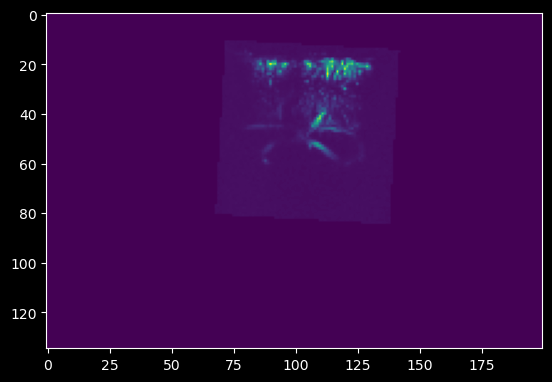

In [4]:
sitk_moving_image = sitk.ReadImage(corrected_2d_file)  # Image A (moving)
sitk_fixed_image = sitk.ReadImage(aligned_2d_file)    # Image C (fixed reference)

with h5py.File(transform_mtx_file, 'r') as f:
    transform_parameters = np.array(f['TransformGroup/0/TransformParameters'])
    fixed_parameters = np.array(f['TransformGroup/0/TransformFixedParameters'])

# Create a SimpleITK AffineTransform (or Euler3DTransform for rigid transformations)
affine_transform = sitk.AffineTransform(3)  # 3D affine transform
affine_transform.SetMatrix(transform_parameters[:9])  # First 9 are rotation/scaling
affine_transform.SetTranslation(transform_parameters[9:12])  # Last 3 are translation

# Optionally: Set the fixed parameters (origin/center) if needed
if len(fixed_parameters) > 0:
    affine_transform.SetFixedParameters(fixed_parameters)

# Resample the moving image (A) to the space of the fixed image (C) using the transform matrix
resampled_image = sitk.Resample(
    sitk_moving_image,                       # Moving image (A)
    sitk_fixed_image,                        # Fixed image (C) for reference space
    affine_transform,                        # Affine transformation matrix M
    sitk.sitkLinear,                         # Interpolation method (linear)
    0.0,                                     # Default value for out-of-bound pixels
    sitk_moving_image.GetPixelID()           # Pixel type from the moving image
)

data = sitk.GetArrayFromImage(resampled_image).transpose(2, 1, 0)
plt.imshow(np.rot90(data[79, :, :]))
plt.show()


In [58]:
data = sitk.GetArrayFromImage(resampled_image).transpose(2, 1, 0)

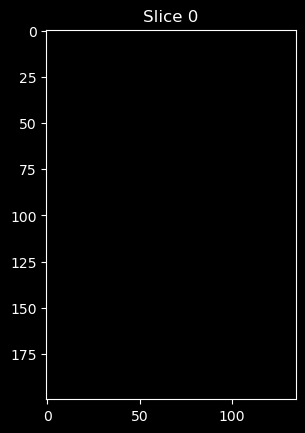

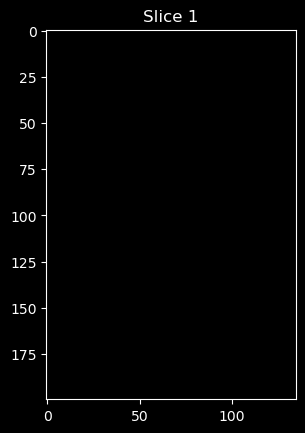

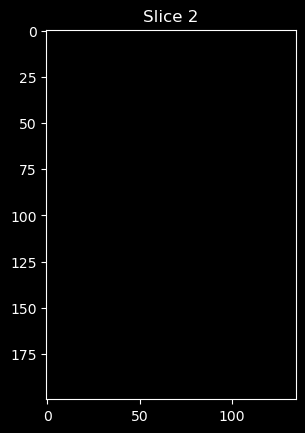

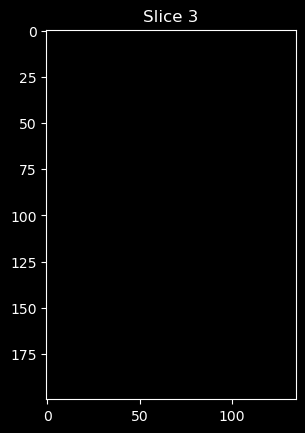

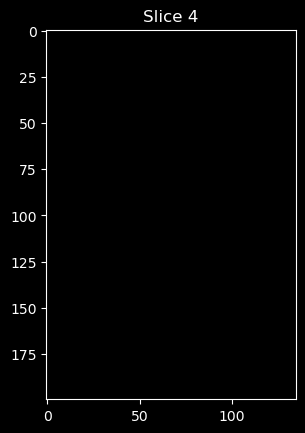

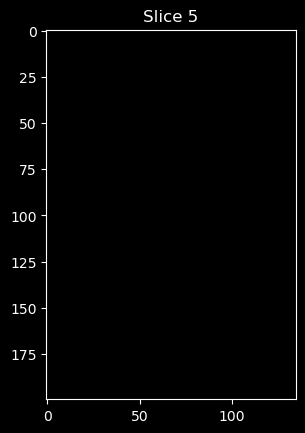

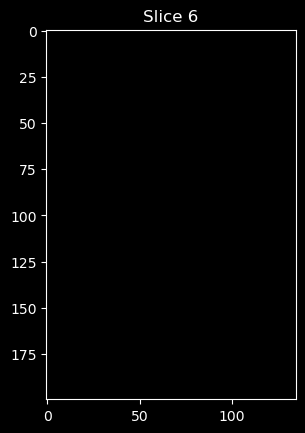

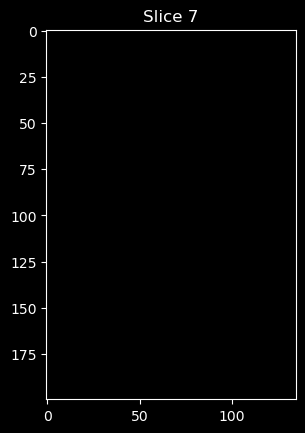

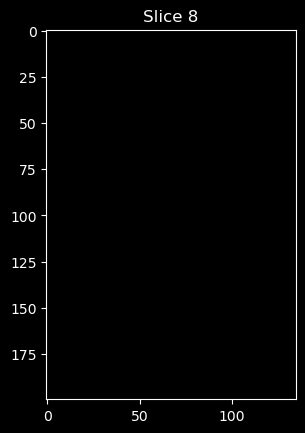

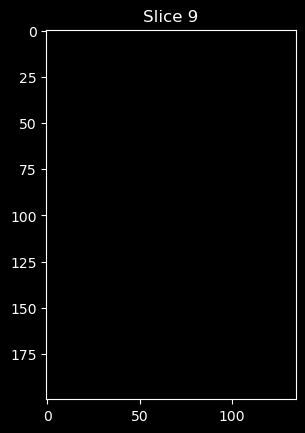

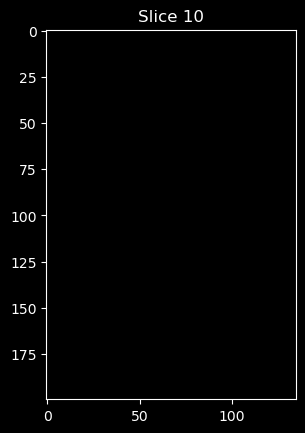

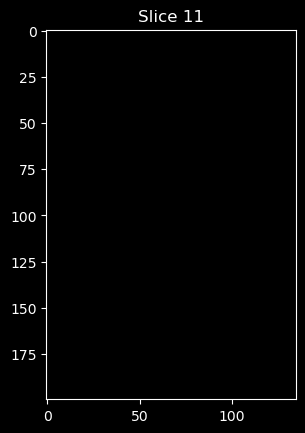

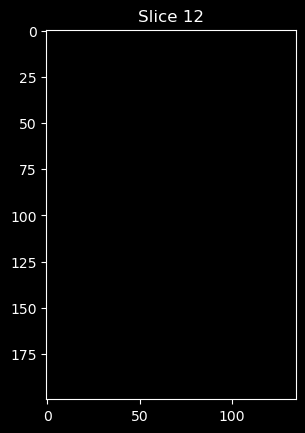

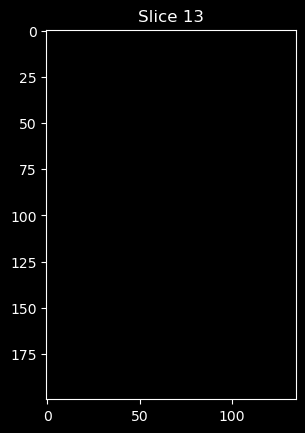

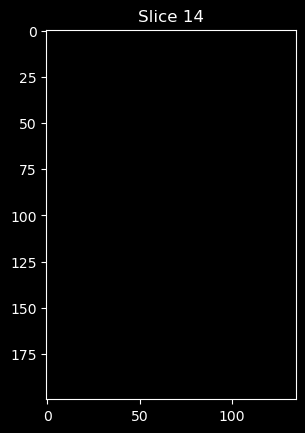

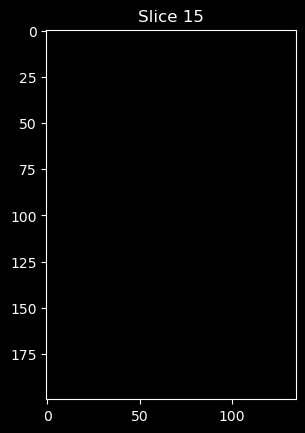

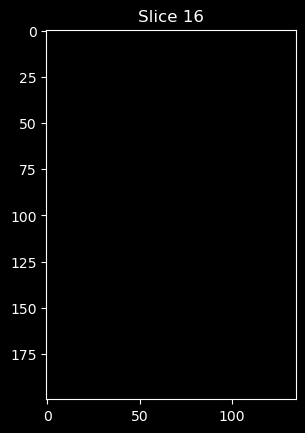

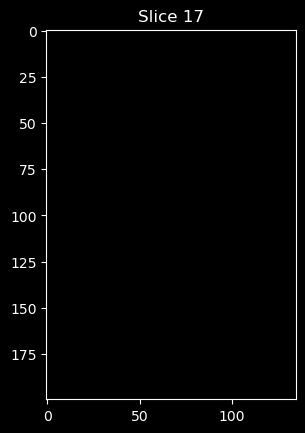

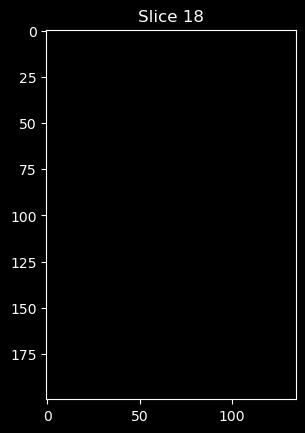

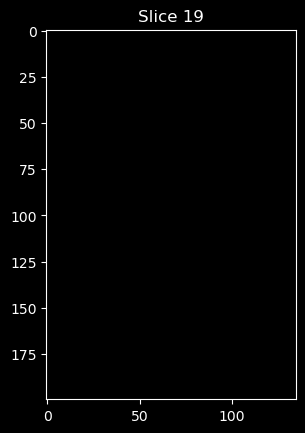

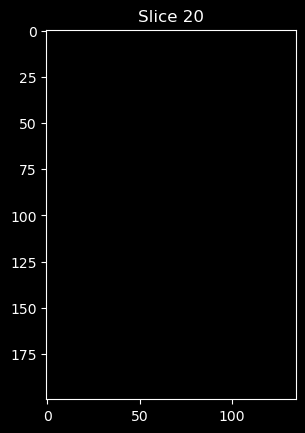

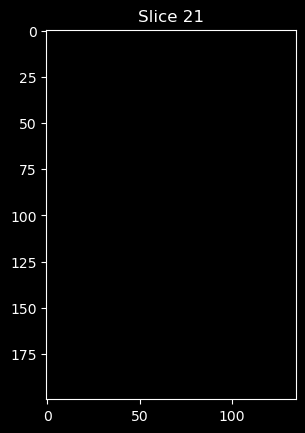

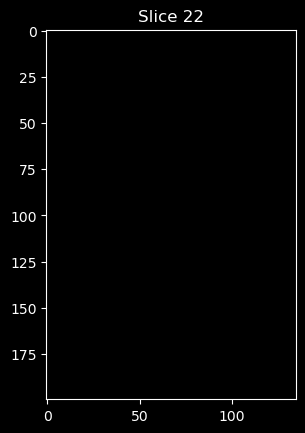

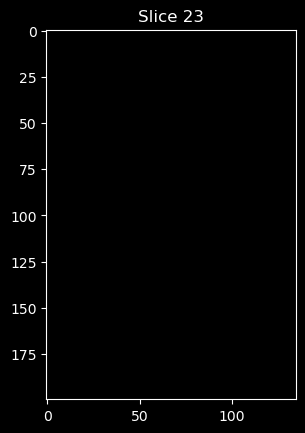

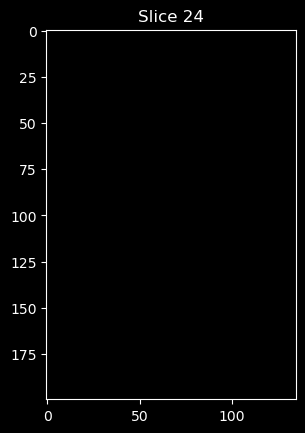

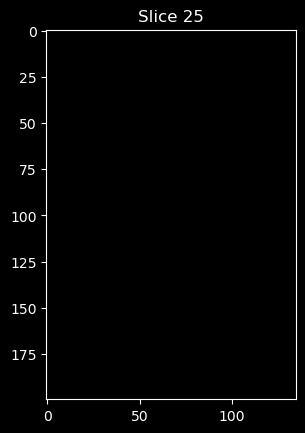

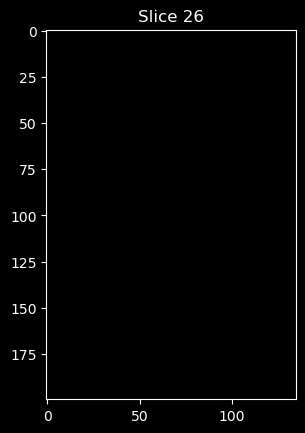

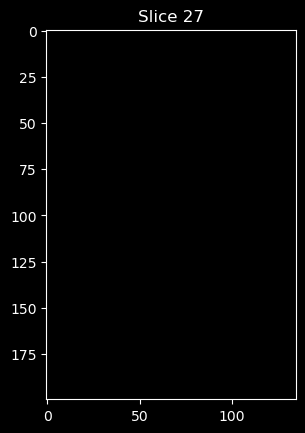

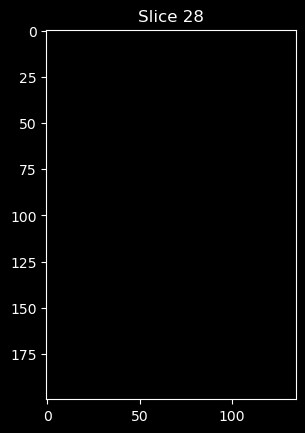

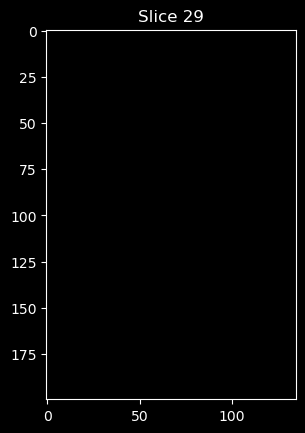

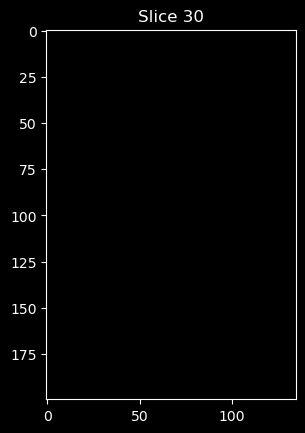

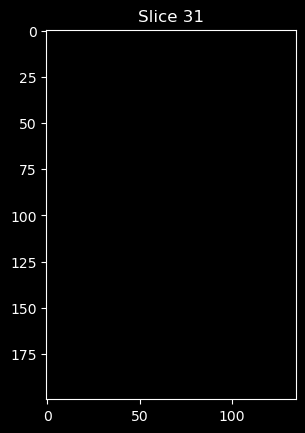

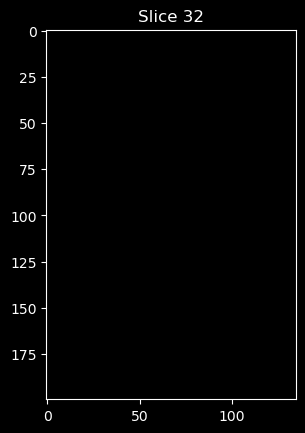

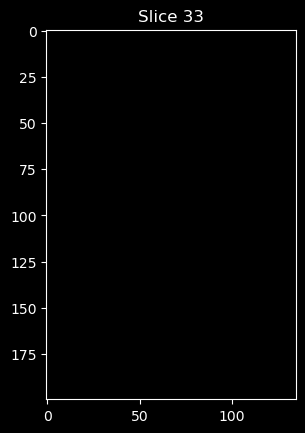

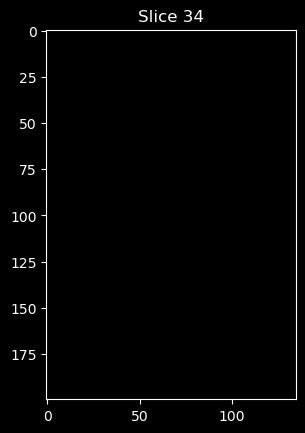

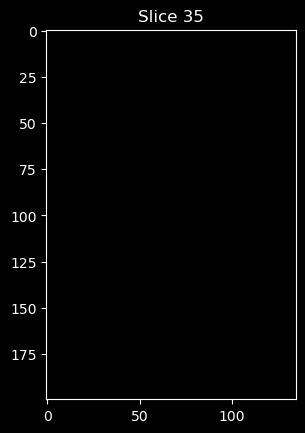

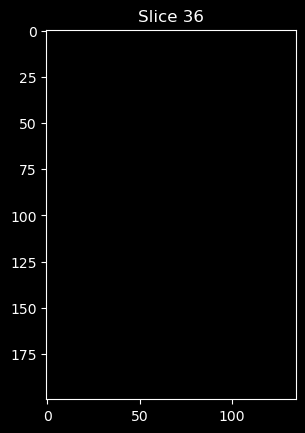

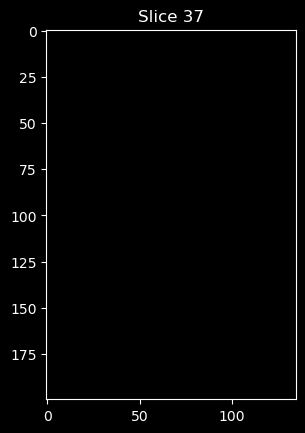

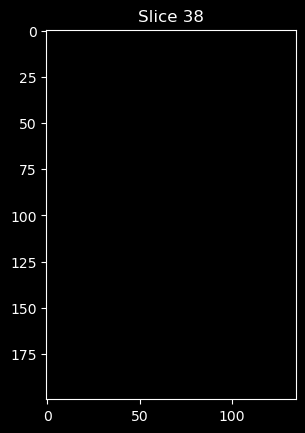

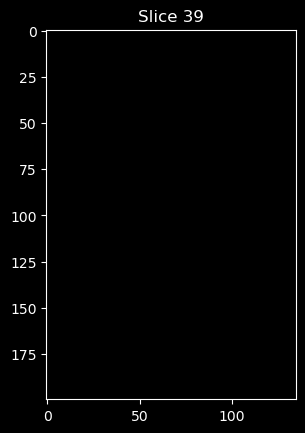

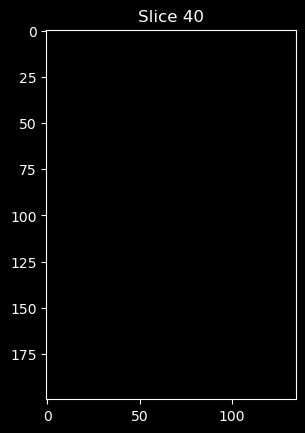

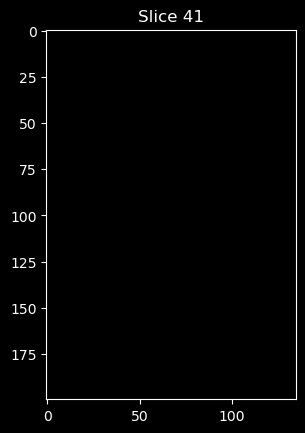

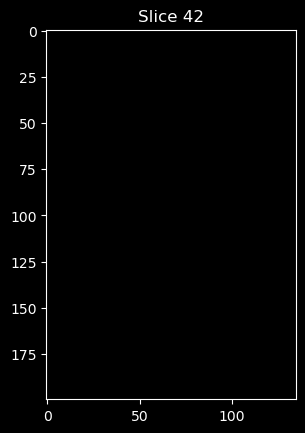

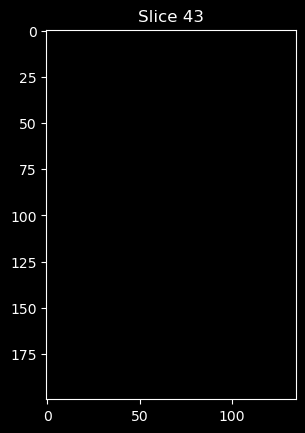

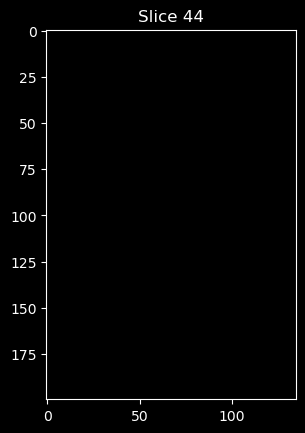

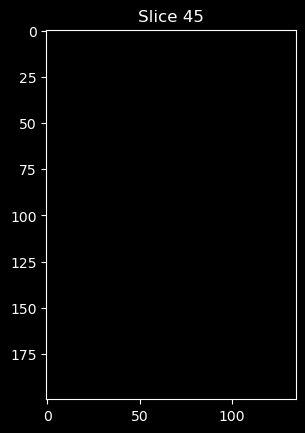

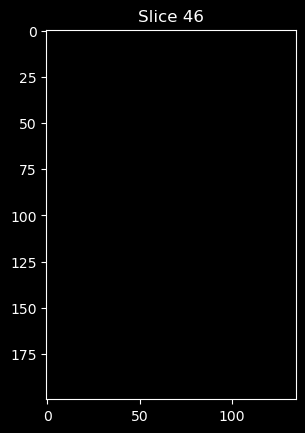

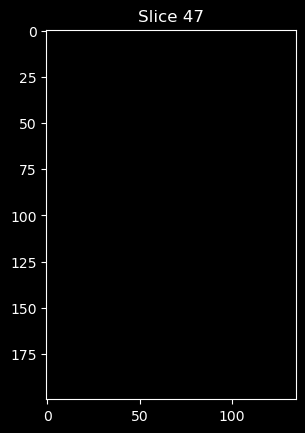

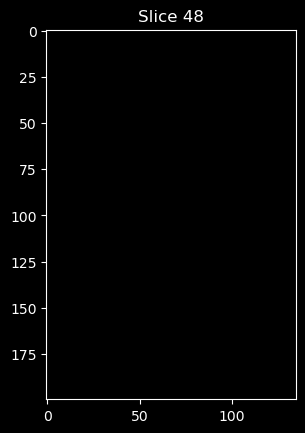

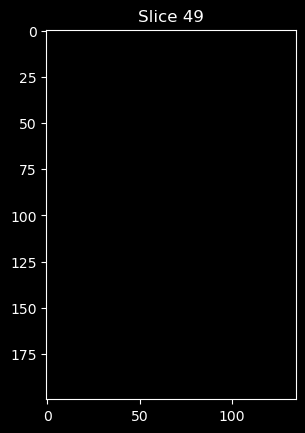

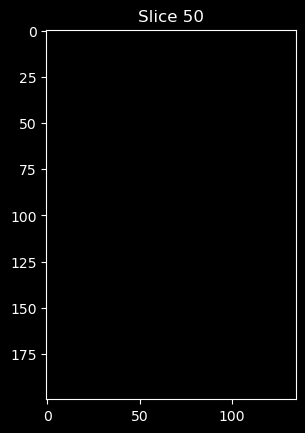

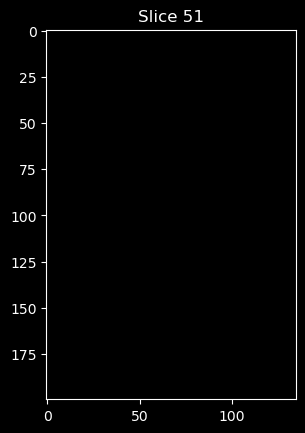

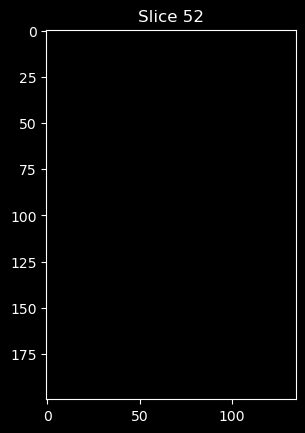

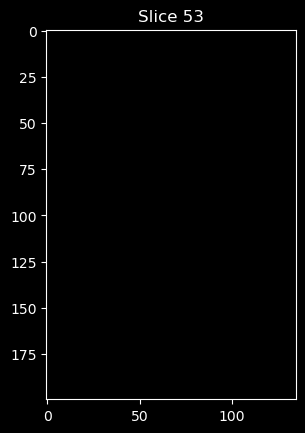

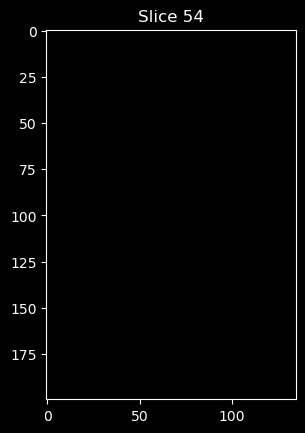

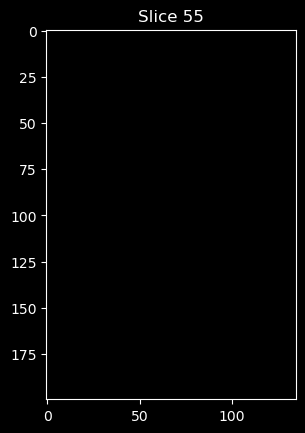

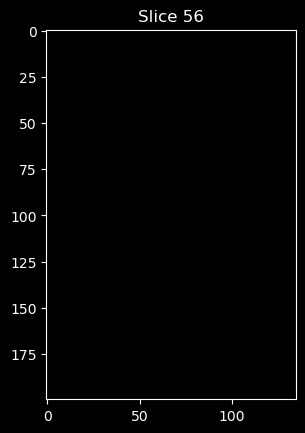

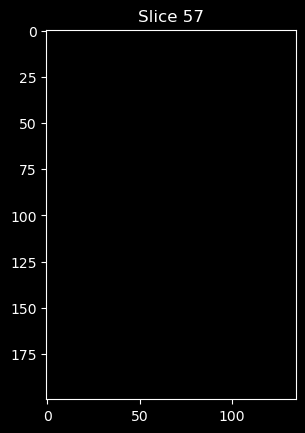

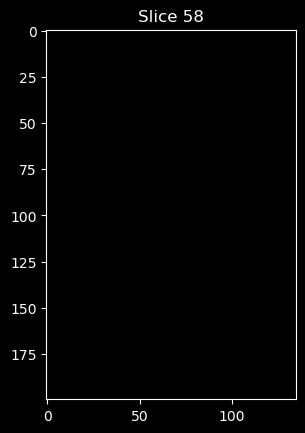

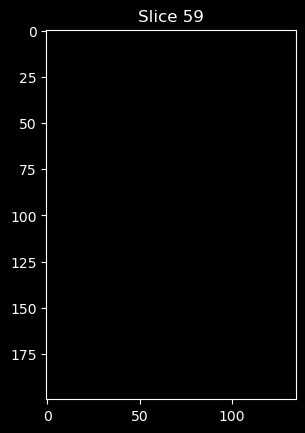

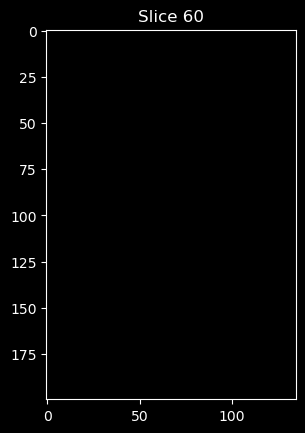

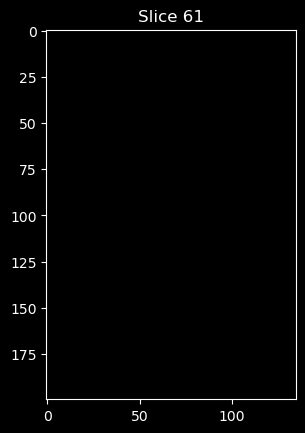

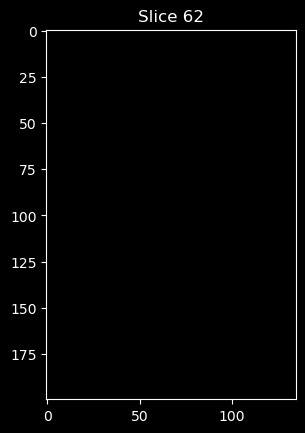

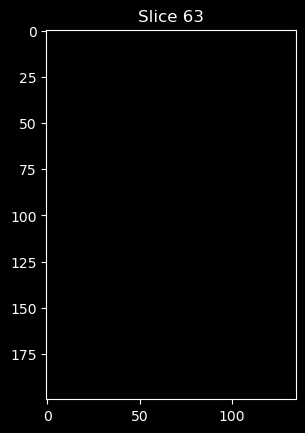

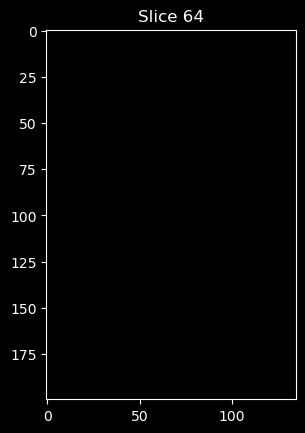

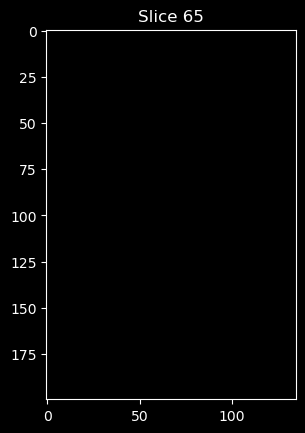

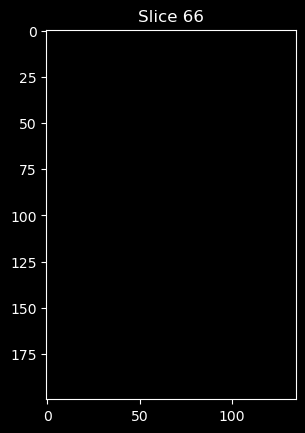

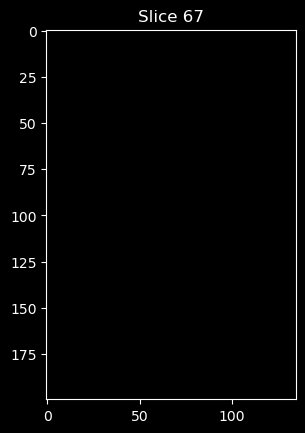

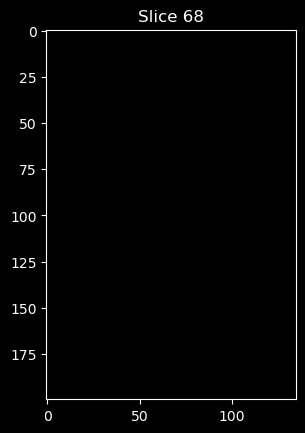

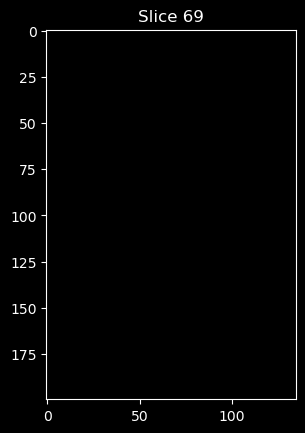

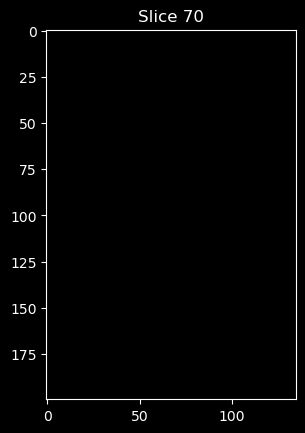

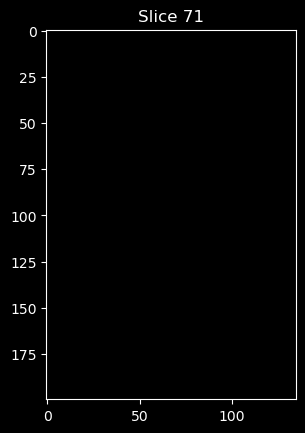

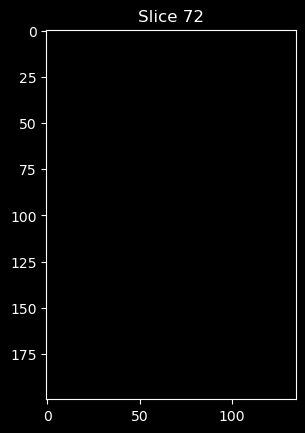

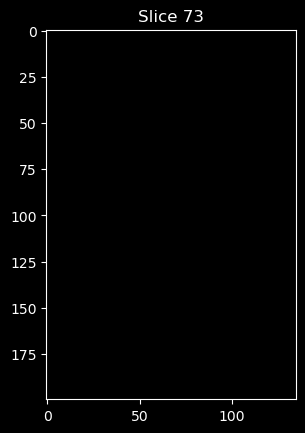

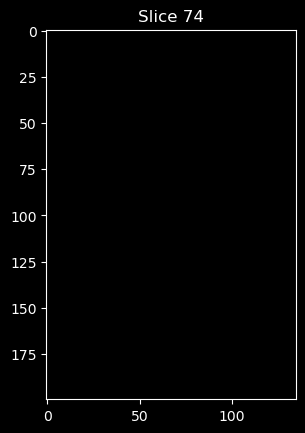

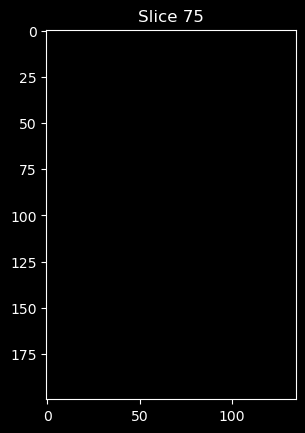

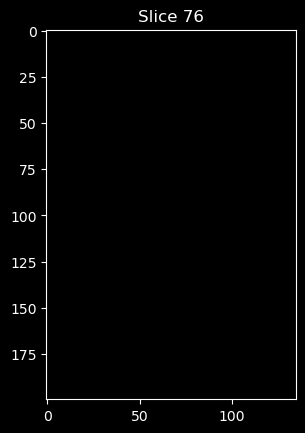

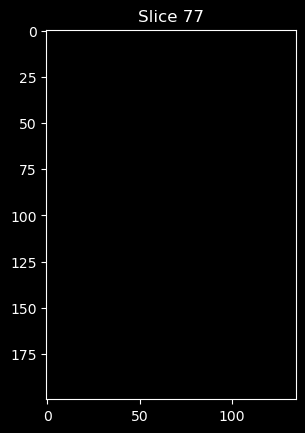

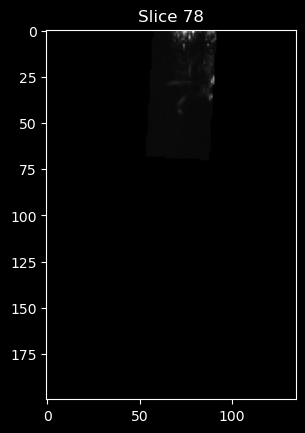

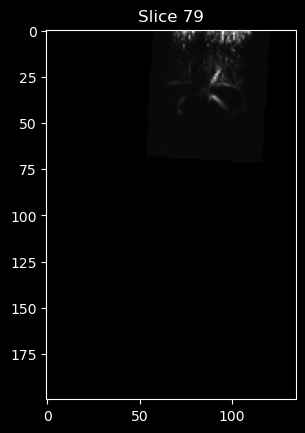

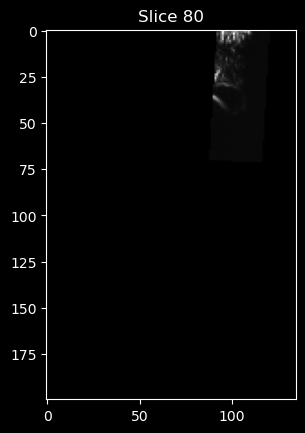

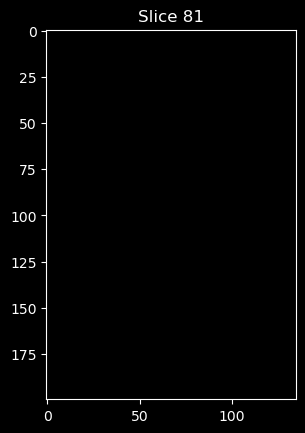

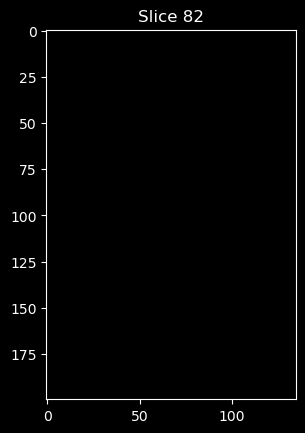

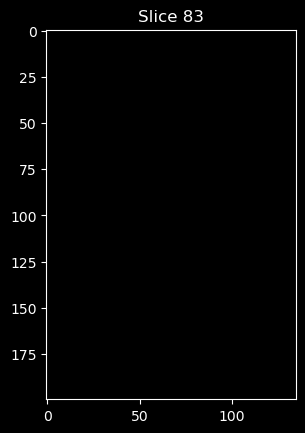

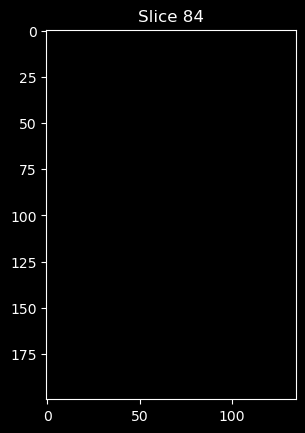

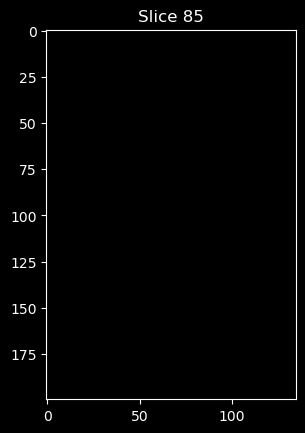

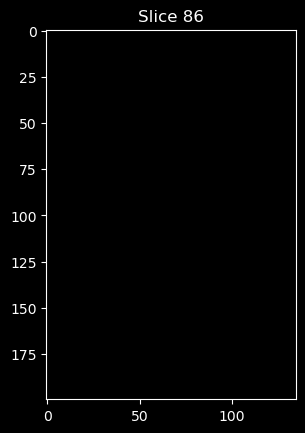

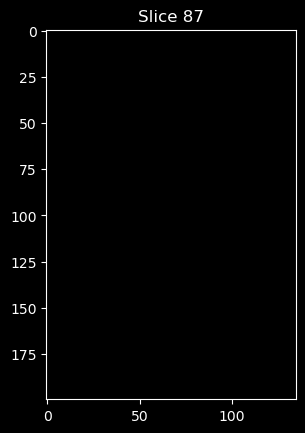

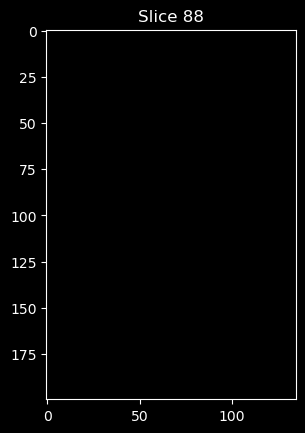

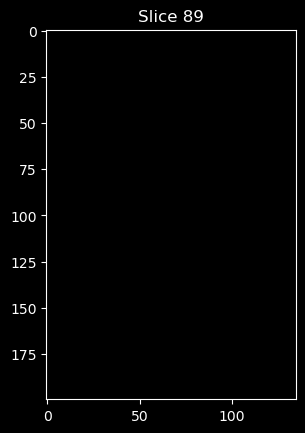

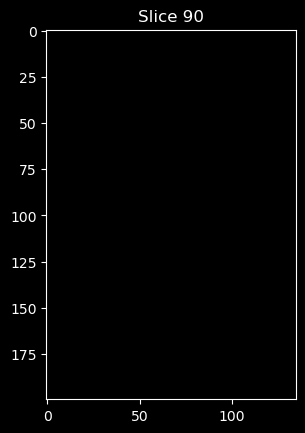

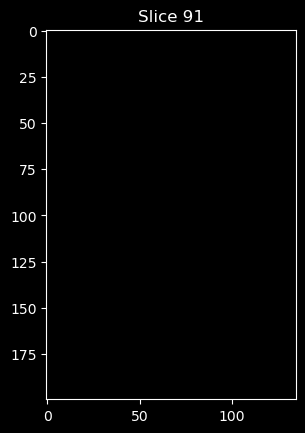

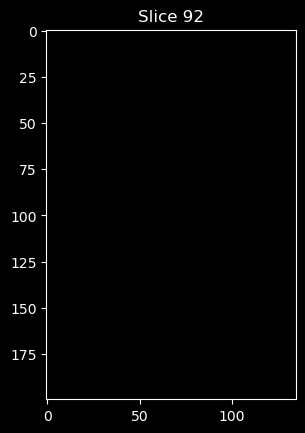

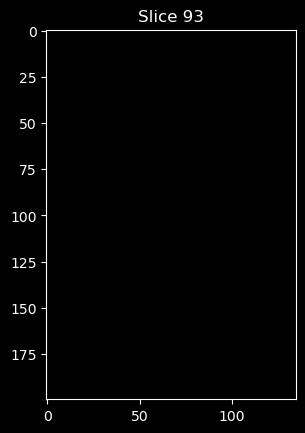

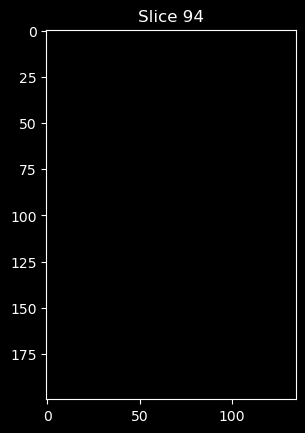

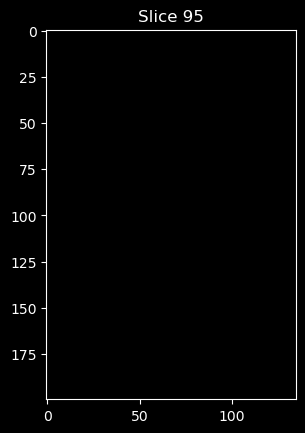

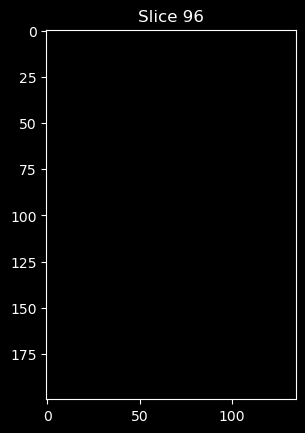

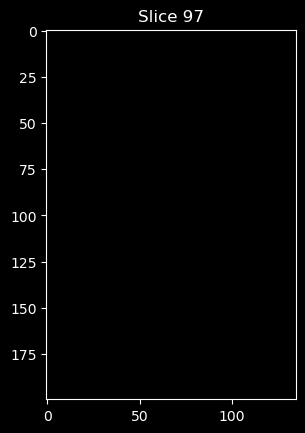

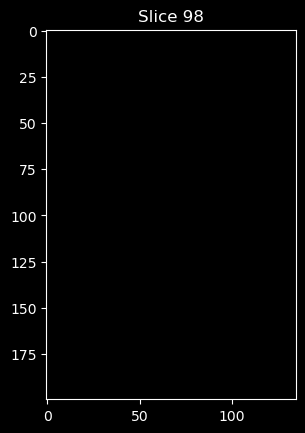

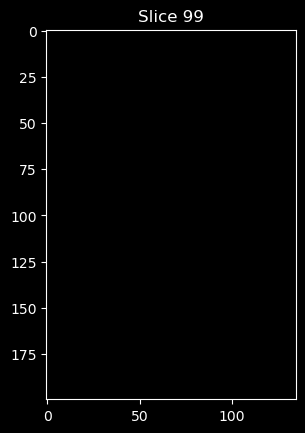

In [80]:
for i in range(100):
    plt.imshow(data[i, :, :], cmap='gray')
    plt.title(f"Slice {i}")
    plt.show()

In [4]:
# Read the 4D moving image using SimpleITK
sitk_moving_4d_image = sitk.ReadImage(corrected_ts_file)
sitk_fixed_image = sitk.ReadImage(aligned_2d_file)

with h5py.File(transform_mtx_file, 'r') as f:
    transform_parameters = np.array(f['TransformGroup/0/TransformParameters'])
    fixed_parameters = np.array(f['TransformGroup/0/TransformFixedParameters'])

affine_transform = sitk.AffineTransform(3) 
affine_transform.SetMatrix(transform_parameters[:9])  
affine_transform.SetTranslation(transform_parameters[9:12]) 

if len(fixed_parameters) > 0:
    affine_transform.SetFixedParameters(fixed_parameters)

num_timepoints = sitk_moving_4d_image.GetSize()[-1] 

# transformed_4d_image = np.zeros((*sitk_fixed_image.GetSize(), num_timepoints), dtype='float32')

In [5]:
def process_time_point(t):
    # Define the extraction size: 3D spatial size and 0 for time dimension (to extract a 3D image)
    extract_size = list(sitk_moving_4d_image.GetSize())
    extract_size[-1] = 0  # Set the time dimension to 0 to extract a 3D slice

    # Define the extraction index: start at (0, 0, 0) in spatial dimensions, at time t
    extract_index = [0, 0, 0, t]

    # Extract the 3D image at time point t
    sitk_moving_image_3d = sitk.Extract(sitk_moving_4d_image, extract_size, extract_index)
    
    # Resample the 3D image to the fixed image space
    resampled_image_3d = sitk.Resample(
        sitk_moving_image_3d,                # Moving 3D image (at time t)
        sitk_fixed_image,                    # Fixed image (C)
        affine_transform,                    # Affine transformation matrix M
        sitk.sitkLinear,                     # Interpolation method (linear)
        0.0,                                 # Default value for out-of-bound pixels
        sitk_moving_image_3d.GetPixelID()    # Pixel type
    )
    
    # Convert to NumPy array and transpose to match NumPy's (x, y, z) axis order
    transformed_array = sitk.GetArrayFromImage(resampled_image_3d).transpose(2, 1, 0)  # From (z, y, x) -> (x, y, z)
    
    return transformed_array, t

# Process each time point in parallel and assign results directly to the pre-allocated array
num_jobs = -1  # Use all available CPUs for parallel processing
results = Parallel(n_jobs=num_jobs)(delayed(process_time_point)(t) for t in tqdm(range(num_timepoints)))

  0%|          | 0/4500 [00:00<?, ?it/s]

  2%|▏         | 72/4500 [01:50<2:23:45,  1.95s/it]

KeyboardInterrupt: 

In [5]:
# Memory-mapped file to save the transformed 4D image (efficient storage on disk)
output_file = 'transformed_4d_image.dat'
shape_3d = (*sitk_fixed_image.GetSize(), num_timepoints)
transformed_4d_image = np.memmap(output_file, dtype='float32', mode='w+', shape=shape_3d)

# Loop over each time point, apply the transformation, and resample the image
for t in tqdm(range(num_timepoints)):
    # Define the extraction size: 3D spatial size and 0 for time dimension (to extract a 3D image)
    extract_size = list(sitk_moving_4d_image.GetSize())
    extract_size[-1] = 0  # Set the time dimension to 0 to extract a 3D slice

    # Define the extraction index: start at (0, 0, 0) in spatial dimensions, at time t
    extract_index = [0, 0, 0, t]

    # Extract the 3D image at time point t
    sitk_moving_image_3d = sitk.Extract(sitk_moving_4d_image, extract_size, extract_index)
    
    # Resample the 3D image to the fixed image space
    resampled_image_3d = sitk.Resample(
        sitk_moving_image_3d,                # Moving 3D image (at time t)
        sitk_fixed_image,                    # Fixed image (C)
        affine_transform,                    # Affine transformation matrix M
        sitk.sitkLinear,                     # Interpolation method (linear)
        0.0,                                 # Default value for out-of-bound pixels
        sitk_moving_image_3d.GetPixelID()    # Pixel type
    )
    
    # Convert to NumPy array and transpose to match NumPy's (x, y, z) axis order
    transformed_array = sitk.GetArrayFromImage(resampled_image_3d).transpose(2, 1, 0)  # From (z, y, x) -> (x, y, z)
    
    # Save the transformed time point directly to the memory-mapped file
    transformed_4d_image[:, :, :, t] = transformed_array

# Flush the data to disk to make sure everything is written
transformed_4d_image.flush()

# Load the memory-mapped file for later use if needed (e.g., to combine into NIfTI)
final_transformed_4d_image = np.memmap(output_file, dtype='float32', mode='r', shape=shape_3d)


  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:38<?, ?it/s]


KeyboardInterrupt: 

In [10]:
np.save(os.path.join(task_dir, 'grouper_livemarmoset_0618_ts_transformed.npy'), transformed_4d_image)

: 

# GLM

In [3]:
brain_filename = os.path.join(task_dir, '0618_livemarmoset_plane1.5.nii')
brain_filename2 = os.path.join(register_dir, 'Grouper_livemarmoset_0618_2D_timepoints_corrected.nii.gz')
event_frame = [750, 1125, 1500, 1875, 2250, 2625, 3000, 3375, 3750, 4125]
event_sec = [300, 450, 600, 750, 900, 1050, 1200, 1350, 1500, 1650]

In [4]:
data_raw = np.squeeze(nib.load(brain_filename).get_fdata())
data_raw2 = np.squeeze(nib.load(brain_filename2).get_fdata())

pixdim[1,2,3] should be positive; setting to abs of pixdim values


In [5]:
data_raw.shape, data_raw2.shape

((128, 143, 4500), (128, 143, 4500))

In [6]:
def plot_preprocessing_steps(data, step_name):
    # Step 1: Heatmap of average across time
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    avg_time_data = np.mean(data, axis=-1)
    sns.heatmap(avg_time_data.T, cmap="viridis")
    plt.title(f"{step_name}: Average Across Time")

    # Step 2: Mean time series (averaging all pixels)
    plt.subplot(1, 2, 2)
    mean_time_series = np.mean(data, axis=(0, 1))
    plt.plot(mean_time_series)
    plt.title(f"{step_name}: Average Across Pixels")
    plt.xlabel("Time (TRs)")
    plt.ylabel("Signal")

    plt.tight_layout()
    plt.show()

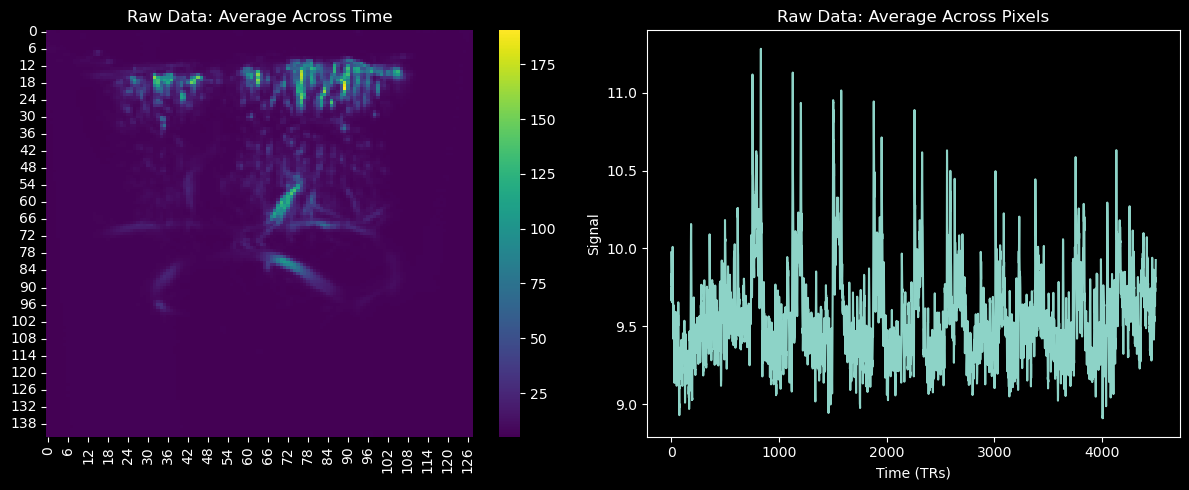

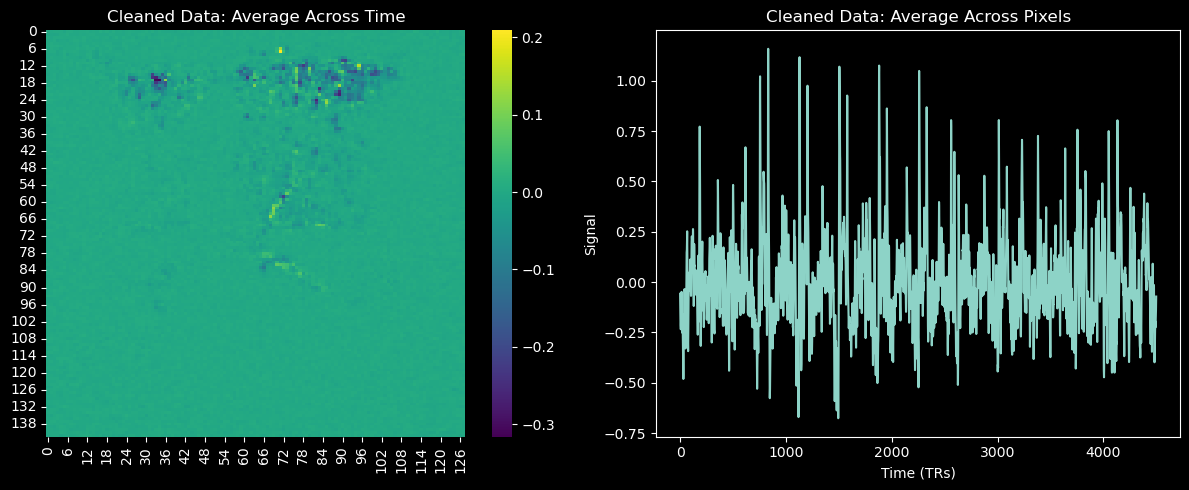

In [9]:
cleaner = FUSCleaner(detrend=True, standardize=False, low_pass=0.8, high_pass=0.01, fs=2.5, sigma=1)

cleaned_data = cleaner.clean(data_raw)

plot_preprocessing_steps(data_raw, "Raw Data")
plot_preprocessing_steps(cleaned_data, "Cleaned Data")


# GLM

In [11]:
event_df = pd.DataFrame(columns=['onset', 'trial_type', 'duration'], index=range(len(event_sec)))

event_df['onset'] = event_sec
event_df['trial_type'] = 'social'
event_df['duration'] = 30

In [12]:
event_df

,onset,trial_type,duration
0,300,social,30
1,450,social,30
2,600,social,30
3,750,social,30
4,900,social,30
5,1050,social,30
6,1200,social,30
7,1350,social,30
8,1500,social,30
9,1650,social,30


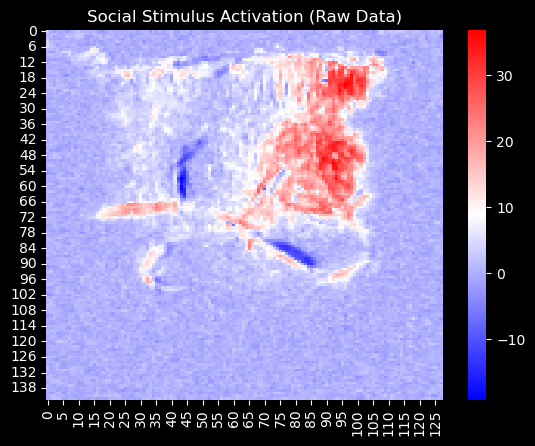

In [28]:
labels, estimators, X = run_glm_analysis(data_raw, event_df)
contrast_matrix = np.eye(X.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
social = compute_contrast(labels, estimators, basic_contrasts['social'], stat_type='t').z_score()
sns.heatmap(social.reshape(cleaned_data.shape[0], cleaned_data.shape[1]).T, cmap="bwr")
plt.title("Social Stimulus Activation (Raw Data)")
plt.show()

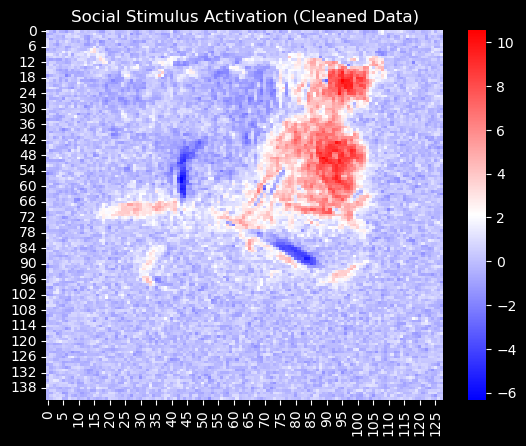

In [29]:
labels, estimators, X = run_glm_analysis(cleaned_data, event_df)
contrast_matrix = np.eye(X.shape[1])
basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in enumerate(X.columns)])
social = compute_contrast(labels, estimators, basic_contrasts['social'], stat_type='t').z_score()
sns.heatmap(social.reshape(cleaned_data.shape[0], cleaned_data.shape[1]).T, cmap="bwr")
plt.title("Social Stimulus Activation (Cleaned Data)")
plt.show()

# PSTH

In [45]:
def compute_psth(data, trial_starts_seconds, trial_length_seconds, fs):
    """
    Compute the PSTH for fUS data.

    Parameters:
    - data: 3D numpy array (x, y, n_TR), the fUS time series data
    - trial_starts_seconds: list or array of start times in seconds for each trial
    - trial_length_seconds: duration of each trial in seconds
    - fs: sampling frequency in Hz (e.g., 2.5 Hz)

    Returns:
    - psth: array of average response across trials for each time point within the trial
    - time_axis: corresponding time axis for plotting (in seconds)
    """
    # Convert trial start times and trial length from seconds to frames (time points)
    trial_starts_frames = (np.array(trial_starts_seconds) * fs).astype(int)
    n_timepoints_per_trial = int(trial_length_seconds * fs)
    
    # Initialize an array to store the responses for each trial
    all_trials = []

    for start in trial_starts_frames:
        # Extract the data for the trial (assuming time is the last axis)
        trial_data = data[..., start:start + n_timepoints_per_trial]
        all_trials.append(trial_data)
    
    # Convert list to numpy array and compute the mean response across trials
    all_trials = np.array(all_trials)
    psth = np.mean(all_trials, axis=0)  # Average across trials
    
    # Create time axis for plotting (each TR converted to seconds)
    time_axis = np.arange(n_timepoints_per_trial) / fs
    
    return psth, time_axis

def plot_psth_all_pixels(psth, trial_starts_seconds, trial_length_seconds, fs):
    """
    Plot a heatmap where the x-axis is labeled with the center of each trial, 
    including '0' at the start, the y-axis is all pixels (flattened), and the color 
    indicates the signal strength.

    Parameters:
    - psth: 3D array of shape (x, y, n_TR) representing the trial-averaged signal
    - trial_starts_seconds: list of trial start times in seconds
    - trial_length_seconds: duration of each trial in seconds
    - fs: sampling frequency in Hz
    """
    # Flatten the spatial dimensions (x, y) into a single dimension
    n_pixels = psth.shape[0] * psth.shape[1]
    reshaped_psth = psth.reshape(n_pixels, -1)

    # Create time axis based on frames converted to seconds
    n_timepoints_per_trial = int(trial_length_seconds * fs)
    time_axis = np.arange(n_timepoints_per_trial) / fs

    # Prepend '0' to the trial starts
    trial_starts_seconds = [0] + trial_starts_seconds
    trial_midpoints = np.array(trial_starts_seconds) + trial_length_seconds / 2
    
    # Plot the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(reshaped_psth, cmap="bwr", cbar=True, xticklabels=np.round(trial_midpoints, 2))
    plt.xticks(np.linspace(0, len(time_axis) - 1, len(trial_midpoints)), labels=np.round(trial_midpoints, 2))
    plt.xlabel("Trial Midpoint (seconds)")
    plt.ylabel("Pixels")
    plt.title("PSTH Heatmap (All Pixels)")
    plt.show()

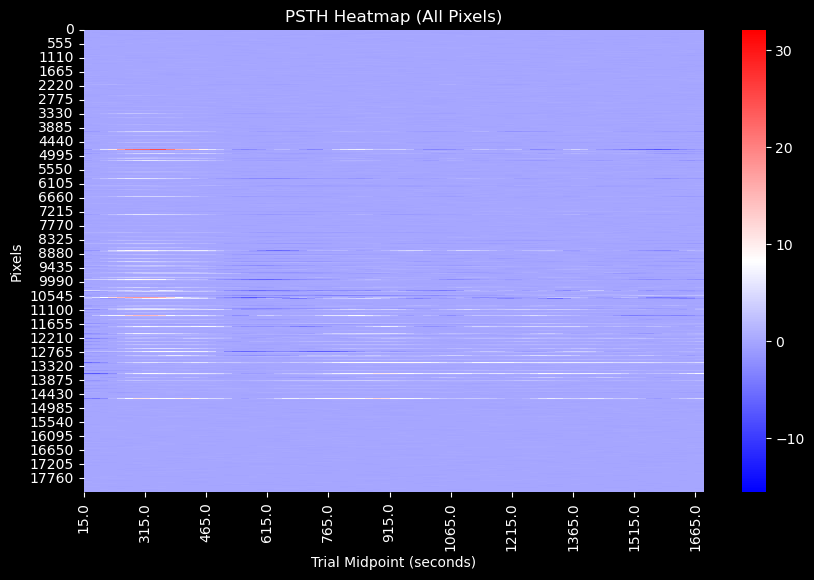

In [46]:
trial_starts = event_sec
fs = 2.5 
trial_length = 30
psth, time_axis = compute_psth(cleaned_data, trial_starts, trial_length, fs)
plot_psth_all_pixels(psth, trial_starts, trial_length, fs)

# Alignment

['HDFVersion', 'ITKVersion', 'OSName', 'OSVersion', 'TransformGroup']
['0']
Transform Parameters: [ 9.99793902e-01 -1.15001113e-03  2.02689588e-02 -7.76484799e-06
  9.98372566e-01  5.70282286e-02 -2.03015555e-02 -5.70166326e-02
  9.98166795e-01  9.17588919e-01 -1.18879569e+00 -7.08504770e+00]
Fixed Parameters: [0. 0. 0.]
Affine Matrix: 
[[ 9.99793902e-01 -1.15001113e-03  2.02689588e-02  9.17588919e-01]
 [-7.76484799e-06  9.98372566e-01  5.70282286e-02 -1.18879569e+00]
 [-2.03015555e-02 -5.70166326e-02  9.98166795e-01 -7.08504770e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [81]:
import SimpleITK as sitk
import h5py
import numpy as np

# Read both images using SimpleITK
sitk_moving_image = sitk.ReadImage(corrected_2d_file)  # Image A (moving)
sitk_fixed_image = sitk.ReadImage(aligned_2d_file)    # Image C (fixed reference)

with h5py.File(transform_mtx_file, 'r') as f:
    transform_parameters = np.array(f['TransformGroup/0/TransformParameters'])
    fixed_parameters = np.array(f['TransformGroup/0/TransformFixedParameters'])

# Create a SimpleITK AffineTransform (or Euler3DTransform for rigid transformations)
affine_transform = sitk.AffineTransform(3)  # 3D affine transform
affine_transform.SetMatrix(transform_parameters[:9])  # First 9 are rotation/scaling
affine_transform.SetTranslation(transform_parameters[9:12])  # Last 3 are translation

# Optionally: Set the fixed parameters (origin/center) if needed
if len(fixed_parameters) > 0:
    affine_transform.SetFixedParameters(fixed_parameters)

# Resample the moving image (A) to the space of the fixed image (C) using the transform matrix
resampled_image = sitk.Resample(
    sitk_moving_image,                       # Moving image (A)
    sitk_fixed_image,                        # Fixed image (C) for reference space
    affine_transform,                        # Affine transformation matrix M
    sitk.sitkLinear,                         # Interpolation method (linear)
    0.0,                                     # Default value for out-of-bound pixels
    sitk_moving_image.GetPixelID()           # Pixel type from the moving image
)

data = sitk.GetArrayFromImage(resampled_image)

 90%|█████████ | 4053/4500 [00:39<00:04, 103.02it/s]

: 

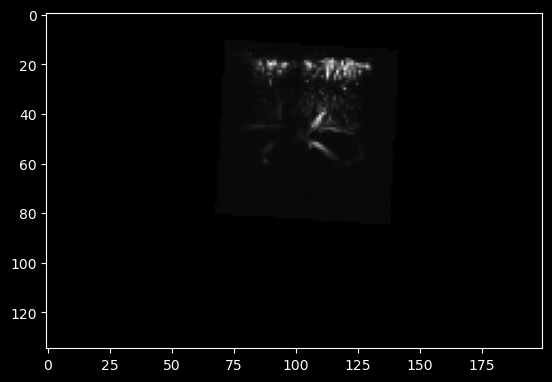

In [89]:
plt.imshow(np.rot90(data[:, :, 79].T), cmap='gray')
plt.show()